# 2D Preprocessing example
Notebook used to preprocess DESI Spectra into 2D images and dump them into pickeld files. 

In [1]:
import numpy as np
from desispec.io import read_spectra
from desispec.interpolation import resample_flux
from glob import glob
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

import os
import platform

 Couldn't install DESITRIP package on NERSC hence rescale and rebin code written below

In [2]:
def rescale_flux(flux):
    """Rescale flux so that it ranges from 0 to 1.
    Parameters
    ----------
    flux : ndarray
        Input flux array.
    Returns
    -------
    rsfl : ndarray
        Flux rescaled to range between 0 and 1.
    """

    if flux.ndim > 1:
        a, b = np.min(flux,axis=1)[:,None], np.max(flux,axis=1)[:,None]
    else:
        a, b = np.min(flux), np.max(flux)
    
    return (flux - a) / (b - a)

In [3]:
def rebin_flux(wave, flux, ivar=None, z=None, minwave=3600., maxwave=9800., nbins=1, log=False, clip=False):
    """Rebin differential flux vs wavelength using desispec resample_flux.
    Parameters
    ----------
    wave : ndarray
        Input wavelength; assume units of Angstroms.
    flux : ndarray
        Input differential spectra as a function of wavelength.
    ivar : None or ndarray
        Inverse variance (weight) of spectra vs wavelength.
    z : None, float, or ndarray
        Known or estimated redshift(s) for input spectra.
    minwave : float
        Minimum output wavelength, in units of Angstroms.
    maxwave : float
        Maximum output wavelength, in units of Angstroms.
    nbins : int
        Number of output wavelength bins.
    log : bool
        If true, use logarithmic bins between minwave and maxwave.
    clip : bool
        If true, clip input values below zero before rescaling.
    Returns
    -------
    basewave : ndarray
        Output wavelength, in units of Angstroms.
    fl : ndarray
        Rebinned spectra.
    iv : ndarray
        Rebinned inverse variance.
    """
    # Choose new binning.
    if log:
        basewave = np.logspace(np.log10(minwave), np.log10(maxwave), nbins)
    else:
        basewave = np.linspace(minwave, maxwave, nbins)

    # Shift to rest frame.
    if z is not None:
        wave = wave/(1+z) if np.isscalar(z) else np.outer(1./(1+z), wave)

    if flux.ndim > 1:
        # Remove spectra with NaNs and zero flux values.
        mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
        mask_idx = np.argwhere(mask)
        flux = np.delete(flux, mask_idx, axis=0)
        ivar = np.delete(ivar, mask_idx, axis=0)
        if wave.ndim > 1:
            wave = np.delete(wave, mask_idx, axis=0)

        nspec = len(flux)
        fl = np.zeros((nspec, nbins))
        iv = np.ones((nspec, nbins))
        for i in range(nspec):
            # Wavelength array may be different for each input flux, e.g., if
            # we shift to the rest frame.
            wave_ = wave[i] if wave.ndim > 1 else wave

            if ivar is not None:
                fl[i], iv[i] = resample_flux(basewave, wave_, flux[i], ivar[i])
            else:
                fl[i] = resample_flux(basewave, wave_, flux[i])
    else:
        resampled = resample_flux(basewave, wave, flux, ivar)
        if ivar is not None:
            fl, iv = resampled
        else:
            fl, iv = resampled, None

    # Enable clipping of negative values.
    if clip:
        fl = fl.clip(min=0)

    return basewave, fl, iv

In [4]:
def condition_spectra(coadd_files, truth_files):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of FITS files on disk with DESI spectra.
    truth_files : list or ndarray
        Truth files.
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = None
    
    for cf, tf in zip(coadd_files, truth_files):
        spectra = read_spectra(cf)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        
        truth = Table.read(tf, 'TRUTH')
        truez = truth['TRUEZ']

#         # Pre-condition: remove spectra with NaNs and zero flux values.
#         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
#         mask_idx = np.argwhere(mask)
#         flux = np.delete(flux, mask_idx, axis=0)
#         ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, truez, minwave=3600., maxwave=9800., nbins=3600, log=False, clip=True)
        rsflux = rescale_flux(reflux)
        
        

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
    
    #,rewave,reflux,wave,flux,ivar
    return fluxes

In [5]:
host_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/hosts/*truth.fits')))
host_coadd= np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/hosts/*coadd.fits')))
host_flux= condition_spectra(host_coadd, host_truth)
#,host_rewave,host_reflux,wavec,fluxc,ivarc

INFO:spectra.py:253:read_spectra: iotime 0.287 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2021-06-09T07:34:04.044994
INFO:spectra.py:253:read_spectra: iotime 0.322 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2021-06-09T07:34:05.068762
INFO:spectra.py:253:read_spectra: iotime 0.255 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2021-06-09T07:34:05.923922
INFO:spectra.py:253:read_spectra: iotime 0.364 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2021-06-09T07:34:06.976741
INFO:spectra.py:253:read_spectra: iotime 0.517 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2021-06-09T07:34:08.089667
INFO:spectra.py:253:read_spectra: iotime 0.357 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2021-06-09T07:34:08.925091
INFO:spectra.py:253:read_spectra: iotime 0.446 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2021-06-09T07:34:09.847725
INFO:spectra.py:253:read_spectra: iotime 0.286 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2021-06-09T07:34:10.741295


In [21]:
snia_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ia/hsiao/*truth.fits')))
snia_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ia/hsiao/*coadd.fits')))
snia_flux  = condition_spectra(snia_coadd, snia_truth)

INFO:spectra.py:253:read_spectra: iotime 0.232 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2021-05-04T06:40:21.084332
INFO:spectra.py:253:read_spectra: iotime 0.192 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2021-05-04T06:40:21.758468
INFO:spectra.py:253:read_spectra: iotime 0.208 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2021-05-04T06:40:22.443891
INFO:spectra.py:253:read_spectra: iotime 0.172 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2021-05-04T06:40:23.085007
INFO:spectra.py:253:read_spectra: iotime 0.178 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2021-05-04T06:40:23.738579
INFO:spectra.py:253:read_spectra: iotime 0.169 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2021-05-04T06:40:24.454052
INFO:spectra.py:253:read_spectra: iotime 0.202 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2021-05-04T06:40:25.128450
INFO:spectra.py:253:read_spectra: iotime 0.174 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2021-05-04T06:40:25.758366


In [22]:
snib_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ib/*/*truth.fits')))
snib_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ib/*/*coadd.fits')))
snib_flux  = condition_spectra(snib_coadd, snib_truth)

INFO:spectra.py:253:read_spectra: iotime 0.285 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2021-05-04T06:41:42.565262
INFO:spectra.py:253:read_spectra: iotime 0.226 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2021-05-04T06:41:43.301822
INFO:spectra.py:253:read_spectra: iotime 0.191 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2021-05-04T06:41:43.995253
INFO:spectra.py:253:read_spectra: iotime 0.198 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2021-05-04T06:41:44.642266
INFO:spectra.py:253:read_spectra: iotime 0.275 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2021-05-04T06:41:45.433162
INFO:spectra.py:253:read_spectra: iotime 0.206 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2021-05-04T06:41:46.161903
INFO:spectra.py:253:read_spectra: iotime 0.226 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2021-05-04T06:41:46.868590
INFO:spectra.py:253:read_spectra: iotime 0.267 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2021-05-04T06:41:47.643097


In [23]:
snic_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ic/*/*truth.fits')))
snic_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ic/*/*coadd.fits')))
snic_flux  = condition_spectra(snic_coadd, snic_truth)

INFO:spectra.py:253:read_spectra: iotime 0.221 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2021-05-04T06:43:44.140168
INFO:spectra.py:253:read_spectra: iotime 0.228 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2021-05-04T06:43:44.819683
INFO:spectra.py:253:read_spectra: iotime 0.221 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2021-05-04T06:43:45.530751
INFO:spectra.py:253:read_spectra: iotime 0.209 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2021-05-04T06:43:46.184011
INFO:spectra.py:253:read_spectra: iotime 0.183 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2021-05-04T06:43:46.853441
INFO:spectra.py:253:read_spectra: iotime 0.207 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2021-05-04T06:43:47.587190
INFO:spectra.py:253:read_spectra: iotime 0.217 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2021-05-04T06:43:48.263561
INFO:spectra.py:253:read_spectra: iotime 0.194 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2021-05-04T06:43:48.928712


In [24]:
sniin_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iin/*/*truth.fits')))
sniin_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iin/*/*coadd.fits')))
sniin_flux  = condition_spectra(sniin_coadd, sniin_truth)

INFO:spectra.py:253:read_spectra: iotime 0.210 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2021-05-04T06:46:07.167847
INFO:spectra.py:253:read_spectra: iotime 0.190 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2021-05-04T06:46:07.854112
INFO:spectra.py:253:read_spectra: iotime 0.183 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2021-05-04T06:46:08.491779
INFO:spectra.py:253:read_spectra: iotime 0.188 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2021-05-04T06:46:09.167854
INFO:spectra.py:253:read_spectra: iotime 0.160 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2021-05-04T06:46:09.791327
INFO:spectra.py:253:read_spectra: iotime 0.166 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2021-05-04T06:46:10.481057
INFO:spectra.py:253:read_spectra: iotime 0.262 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2021-05-04T06:46:11.199592
INFO:spectra.py:253:read_spectra: iotime 3.417 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2021-05-04T06:46:16.884898


In [25]:
sniip_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iip/*/*truth.fits')))
sniip_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iip/*/*coadd.fits')))
sniip_flux  = condition_spectra(sniip_coadd, sniip_truth)

INFO:spectra.py:253:read_spectra: iotime 0.175 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2021-05-04T06:50:37.909099
INFO:spectra.py:253:read_spectra: iotime 0.205 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2021-05-04T06:50:38.607492
INFO:spectra.py:253:read_spectra: iotime 0.326 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2021-05-04T06:50:39.461028
INFO:spectra.py:253:read_spectra: iotime 0.221 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2021-05-04T06:50:40.163831
INFO:spectra.py:253:read_spectra: iotime 0.180 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2021-05-04T06:50:40.829563
INFO:spectra.py:253:read_spectra: iotime 0.239 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2021-05-04T06:50:41.550339
INFO:spectra.py:253:read_spectra: iotime 0.207 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2021-05-04T06:50:42.212946
INFO:spectra.py:253:read_spectra: iotime 0.217 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2021-05-04T06:50:42.906882


### Stack the spectra for image

In [6]:
def to_2d(flux):
    
    return_flux=[]
    for i in range(len(flux)):
        trial=flux[i][0:6241]
        trial=((trial-np.min(trial))/(np.max(trial) - np.min(trial)))
        trial=trial.reshape(60,60)
        return_flux.append(trial)
        
    bad_host_counter=0
    final_flux=[]
    for i in return_flux:
        if np.sum(i)==0 or np.isnan(np.sum(i)):
            bad_host_counter=bad_host_counter+1
        else:
            final_flux.append(i)
    
    return final_flux

In [8]:
host_2d=to_2d(host_flux)
snia_2d=to_2d(snia_flux)
snib_2d=to_2d(snib_flux)
snic_2d=to_2d(snic_flux)
sniin_2d=to_2d(sniin_flux)
sniip_2d=to_2d(sniip_flux)

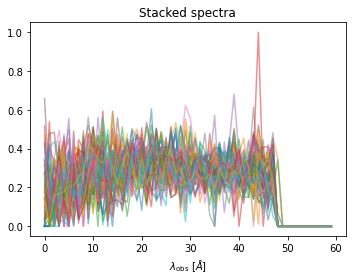

In [9]:
fig,ax= plt.subplots(1,1, figsize=(5,4), tight_layout=True)
ax.plot(host_2d[3], alpha=0.5)
ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='Stacked spectra')
fig.tight_layout()

In [10]:
fig.savefig('stacked_spec.png')

### Save the new data

In [28]:
import pickle

with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/Larger Image/host_flux.data', 'wb') as f:
    pickle.dump(host_2d, f)
    
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/Larger Image/snia_flux.data', 'wb') as f:
    pickle.dump(snia_2d, f) 
    
    
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/Larger Image/snib_flux.data', 'wb') as f:
    pickle.dump(snib_2d, f) 
        
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/Larger Image/snic_flux.data', 'wb') as f:
    pickle.dump(snic_2d, f) 
        
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/Larger Image/sniin_flux.data', 'wb') as f:
    pickle.dump(sniin_2d, f) 
     
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/Larger Image/sniip_flux.data', 'wb') as f:
    pickle.dump(sniip_2d, f) 
       

## Visual check of all preprocessing steps
Ensure " host_rewave,host_reflux,wavec,fluxc,ivarc " have not been commented out as outputs of condition spectra 

No handles with labels found to put in legend.


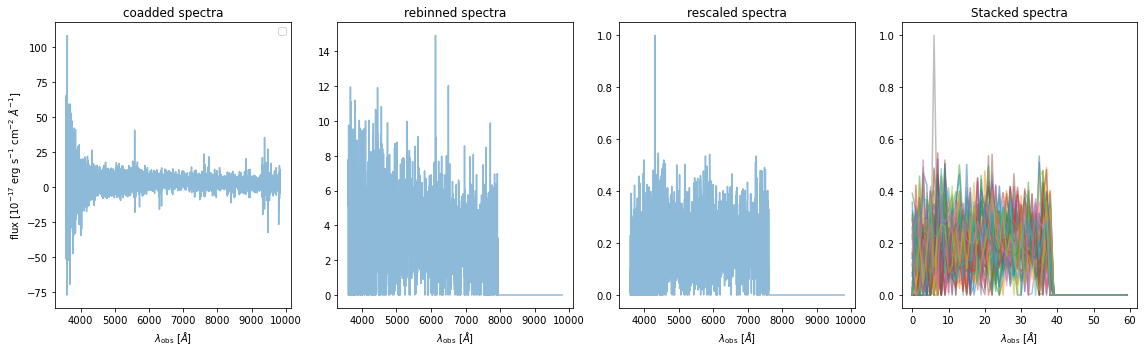

In [13]:
fig, axes = plt.subplots(1,4, figsize=(16,5))

for i in range(6,7):
    
    
    ax = axes[0]
    ax.plot(wavec, fluxc[i], alpha=0.5)

    ax = axes[1]
    ax.plot(host_rewave, host_reflux[i], alpha=0.5)
    
    ax = axes[2]
    ax.plot(host_rewave, host_flux[i], alpha=0.5)
    
    ax = axes[3]
    ax.plot(host_2d[i], alpha=0.5)
    
axes[0].legend(fontsize=10, ncol=2)

axes[0].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            ylabel=r'flux [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]',
            title='coadded spectra')
axes[1].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='rebinned spectra')
axes[2].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='rescaled spectra')
axes[3].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
            title='Stacked spectra')
fig.tight_layout()